In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


In [3]:
housing = datasets.load_boston()
X = pd.DataFrame(housing.data, columns = housing.feature_names)
X.head()
y = housing.target

/Users/arseniybileckiy/PycharmProjects/Database3/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets i

In [4]:
housing.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

CRIM - уровень преступности на душу населения

ZN - доля земель под жилую застройку, зонированных под участки площадью более 25 000 кв. футов

INDUS - доля акров, не связанных с розничной торговлей, на город

CHAS - фиктивная переменная реки Чарльз (= 1, если участок ограничивает реку; 0 в противном случае)

NOX - уровень закиси азота (частей на 10 миллионов)

RM - среднее количество комнат в доме.

AGE - доля частных домов, построенных до 1940 года.

DIS - взвешенные расстояния до пяти бостонских центров занятости

RAD - индекс доступности радиальных автомагистралей.

TAX - ставка налога на недвижимость 

PTRATIO - соотношение числа учащихся и преподавателей в районе 

B - 1000 (Bk - 0,63)², где Bk - доля лиц афроамериканского происхождения по городам.

LSTAT - процент населения с более низким статусом

Целевая переменная - средняя стоимость домов в тысячах долларов

Посмотрим, как коррелируют признаки друг с другом и с целевой переменной. Видим, что есть нелинейные зависимости.

In [5]:
X2 = X.copy() #Делаем DataFrame X2, чтобы добавить в него целевую переменную и выводить корреляции вместе с ней
X2['y'] = y

KeyboardInterrupt: 

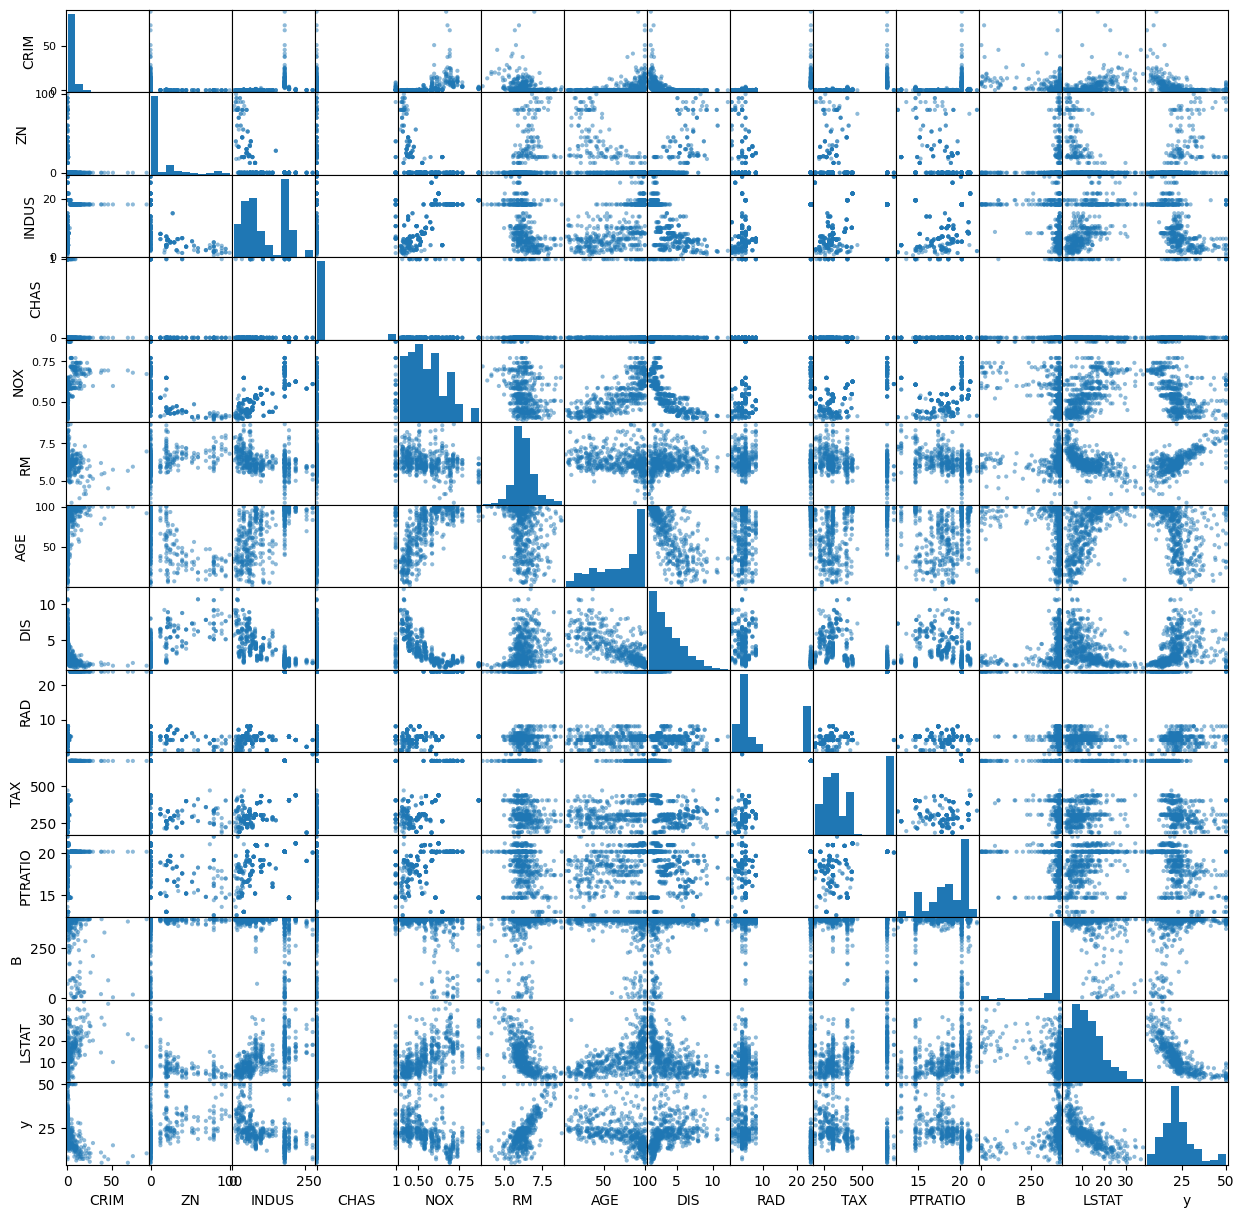

In [6]:
scatter = pd.plotting.scatter_matrix(X2, alpha=0.5, figsize = (15,15))

In [12]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.15, random_state=7)
# X=np.array(X)
# y=np.array(y)
# X_train, X_test, y_train, y_test = train_test_split(Xx, Yy, test_size=0.15, random_state=7)

In [13]:
X.boxplot(grid=False, figsize=(10,5))

AttributeError: 'numpy.ndarray' object has no attribute 'boxplot'

Замена экстремальных выбросов более 15IQR на значение границы 15IQR может немного улучшить результат модели (дополнительное задание для желающих)

In [381]:
# col=['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
# for i in range(len(col)): 
#     Q1 = X_train[col[i]].quantile(0.25)
#     Q3 = X_train[col[i]].quantile(0.75)
#     IQR15=1.5*(Q3-Q1)
#     lower=Q1-IQR15
#     upper=IQR15+Q3
#     if col[i]=='TAX':
#         print(IQR15+Q3,Q1-IQR15,IQR15,Q1,Q3)
#     X_train[col[i]][X_train[col[i]]>upper]=upper
#     X_train[col[i]][X_train[col[i]]<lower]=lower

# X_train.boxplot(grid=False, figsize=(10,5))
c = np.logspace(-3,3,7)
c

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

Вся тренировка, настройка, оценка будет проходить на X_train, y_train. X_test, y_test - для финальной оценки

Дополнительно к имеющимся признакам сгенерируем полиномиальные признаки. В качестве модели возьмем линейную модель с L1 регуляризацией. В оценщике необходимо задать параметр max_iter = 50000, tol=0.01 - увеличить количество эпох, чтобы подойти ближе к точки минимума.

Используем конвейер, не забываем про масштабирование. Для масштабирования лучше использовать вариант не снижающий значимость выбросов.

Подобрать параметры - степень полинома 1-2, коэффициент регуляризации модели - степени 10 от -3 до 3.
Кросс-валидация на 5ти блоках, scoring = 'r2'

In [397]:

pipe = Pipeline(steps=[     ('scaler', MinMaxScaler()),
                            ('preprocessor', PolynomialFeatures(k)),
                                    ('estimator', Lasso())])

# pipe.get_params()

In [398]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
c = np.logspace(-3,3,7)
param_grid = {'preprocessor__degree': [1,2], 'estimator__alpha': c, 'estimator__max_iter': [50000], 'estimator__tol': [0.01]}
grid_search = GridSearchCV(pipe, param_grid,cv=kfold)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('preprocessor', PolynomialFeatures()),
                                       ('estimator', Lasso())]),
             param_grid={'estimator__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'estimator__max_iter': [50000],
                         'estimator__tol': [0.01],
                         'preprocessor__degree': [1, 2]})

In [399]:
print(grid_search.best_params_)

{'estimator__alpha': 0.01, 'estimator__max_iter': 50000, 'estimator__tol': 0.01, 'preprocessor__degree': 2}


In [354]:
c = np.logspace(-3,3,7)
model=[]
for k in range(1,3):
    for i in range(len(c)):
        pipe = Pipeline(steps=[     ('preprocessor', PolynomialFeatures(k)),
                                    ('scaler', MinMaxScaler()),
                                    ('estimator', Lasso(max_iter = 50000, tol=0.01,alpha=c[i]))])

        models.append(pipe.fit(X_train,y_train))
    
    
 
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
mean = []
accuracy=[]  
for i in range (len(models)):
    mean = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        models[i].fit(X_train, y_train)
        y_pred = models[i].predict(X_test)
        mean.append(r2_score(y_test, y_pred).round(2))
#     print(mean)
    accuracy.append(np.array(mean).mean().round(2))
    
    
print(accuracy[:7])
print(accuracy[7:])


[0.66, 0.66, 0.61, 0.24, -0.01, -0.01, -0.01]
[0.9, 0.86, 0.71, 0.3, -0.01, -0.01, -0.01]


In [355]:
models[0][0].n_output_features_

14

In [356]:
# w=np.array(pipe.named_steps['models'].coef_)
# w
num_param=[]
for i in range(len(models)):
    num_param.append((abs(models[0].named_steps['estimator'].coef_)>1).sum())
num_param    

[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]

Какие параметры оказались лучшими?
### 2-я степень полинома. с=10ˆ-3
В качестве оценщика можно использовать grid_search.best_estimator_ 
Сколько получилось признаков после применения полиномизации? (у объекта PolynomialFeatures свойство .n_output_features_) 
### 14 
После регуляризации L1 сколько признаков значимо (имеют абсолютное значение больше единицы) Hint. sum([True,False,False]) = 1
### 13

Оценить качество на отложенной выборке. В качестве оценщика можно взять grid_search.best_estimator_.
Вывести RMSE, r2. R2 должно получиться 0.8 и больше

In [357]:
y_pred=models[7].predict(X_test)
round(r2_score(y_test, y_pred),2)


0.87

Проверить остатки на гомоскедастичность и нормальное распределение

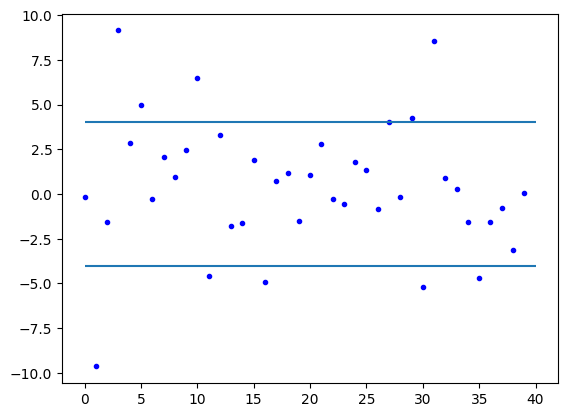

In [383]:
residuals=y_pred-y_test
plt.plot(residuals, "b.")
plt.hlines(-4, 0, 40)
plt.hlines(4, 0, 40)

array([[<Axes: title={'center': '0'}>]], dtype=object)

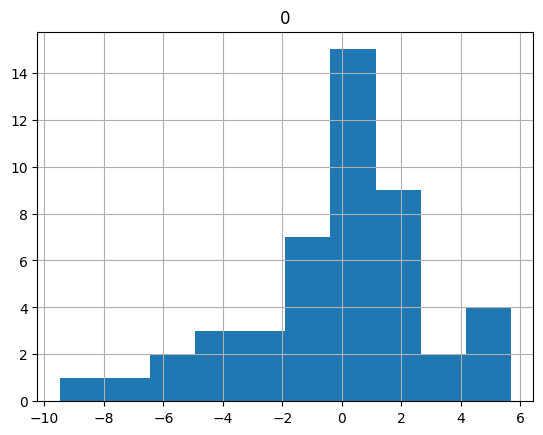

In [348]:
from pandas import DataFrame
df = DataFrame(residuals)

df.hist(bins=10)

<Axes: ylabel='Density'>

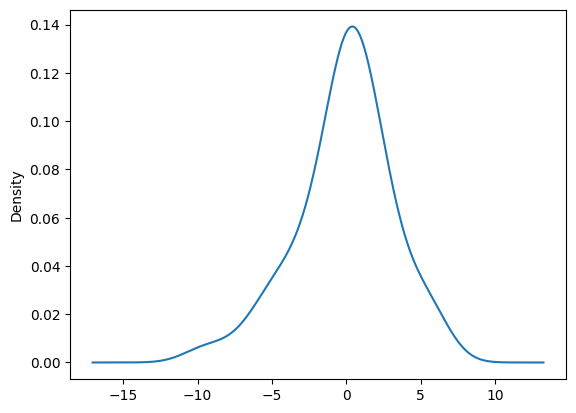

In [349]:
df.plot(kind='kde', legend = False) 

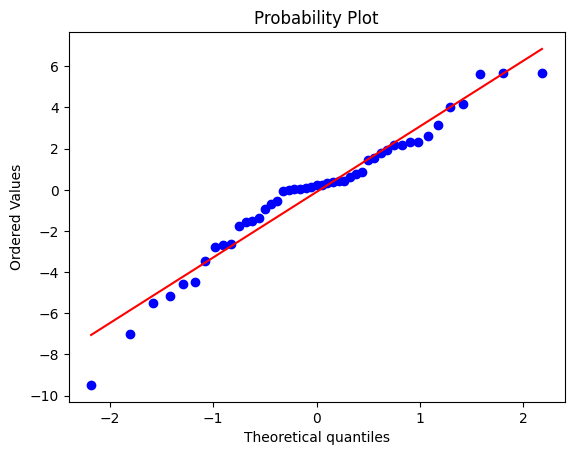

In [350]:
import scipy
residulas1dim = residuals[:]
qq = scipy.stats.probplot(residulas1dim, dist="norm", plot=plt)

Увеличится ли качество на отложенной выборке, если для обучения взять больше образцов? (test_size 10% вместо 15% и модель из новых 5% )

In [ ]:
да